<a href="https://www.kaggle.com/code/ahmetekiz/tps-aug-2022-blending?scriptVersionId=105980651" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Tabular Playground Series - Aug 2022

In this notebook, I create base model for TPS Aug 2022. In below, some information about data is gave us. 

>This data represents the results of a large product testing study. For each **product_code** you are given a number of product **attributes** (fixed for the code) as well as a number of **measurement values** for each individual product, representing various lab testing methods. Each product is used in a simulated real-world environment experiment, and and absorbs a certain amount of fluid (**loading**) to see whether or not it fails.

>Your task is to use the data to predict individual product failures of new codes with their individual lab test results.

**Evaluation**: Submissions are evaluated on area under the ROC curve between the **predicted probability** and the observed target.

1. My First Notebook on this Competition: https://www.kaggle.com/code/ahmetekiz/tps-aug-2022-starter

### This notebook's progress
Blending auc score - submission score
1. optimized models blending and with missing values columns: 0.58764 - 0.58318
1. basic models blending and without missing values columns: 0.58799 - 0.58473

<a id="0"></a> <br>
# Table of Contents    
1. [A Glance at the Data](#2) 
1. [Missing Values](#4)
1. [Preprocess](#5)
1. [Create Folds](#6)
1. [Train and Make Predictions](#7)
    1. [LogisticRegression](#8)
    1. [XGBoost](#9)
    1. [CatBoostClassifier](#10)
    1. [LGBMClassifier](#11)
    1. [Tensorflow ANN Model](#14)
1. [Merge New Sets](#17)
1. [Blending Results](#18)
1. [Submission](#30)

<a id="2"></a> <br>
# A Glance at the Data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import GroupKFold
from sklearn import model_selection

# Metrics
from sklearn.metrics import roc_auc_score

# Model
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from colorama import Fore, Back, Style

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


In [2]:
df_train_full = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/train.csv", index_col='id')
df_test = pd.read_csv("/kaggle/input/tabular-playground-series-aug-2022/test.csv", index_col='id')

df_train = df_train_full.drop(['failure'], axis=1)

In [3]:
df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0


In [4]:
df_train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26570 entries, 0 to 26569
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   product_code    26570 non-null  object 
 1   loading         26320 non-null  float64
 2   attribute_0     26570 non-null  object 
 3   attribute_1     26570 non-null  object 
 4   attribute_2     26570 non-null  int64  
 5   attribute_3     26570 non-null  int64  
 6   measurement_0   26570 non-null  int64  
 7   measurement_1   26570 non-null  int64  
 8   measurement_2   26570 non-null  int64  
 9   measurement_3   26189 non-null  float64
 10  measurement_4   26032 non-null  float64
 11  measurement_5   25894 non-null  float64
 12  measurement_6   25774 non-null  float64
 13  measurement_7   25633 non-null  float64
 14  measurement_8   25522 non-null  float64
 15  measurement_9   25343 non-null  float64
 16  measurement_10  25270 non-null  float64
 17  measurement_11  25102 non-null 

In [5]:
df_train_full.describe()

,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,measurement_6,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,25774.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,17.510759,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,0.995980,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,12.715000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,16.839000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,17.516000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,18.178000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,21.543000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


### Ratio of the Failure on Train Set

0    20921
1     5649
Name: failure, dtype: int64


Text(0.5, 1.0, 'Failure Rate of Products on Training Set')

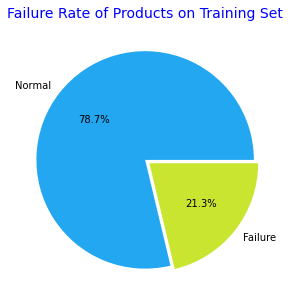

In [6]:
colors = ["#22a7f0","#c9e52f"]
labels = ['Normal', 'Failure']
explode = [0,0.05]

print(df_train_full.failure.value_counts())
           
plt.figure(figsize = (5,5))
plt.pie(df_train_full.failure.value_counts(),explode=explode, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Failure Rate of Products on Training Set", color = 'blue',fontsize = 14)

### Ratio of Nan Values
There is a lot of missing value. We will deal with them later.

In [7]:
cm = sns.light_palette("yellow", as_cmap=True)
pd.DataFrame({"NaN Count": df_train_full.isna().sum(),
              "NaN Ratio": df_train_full.isna().sum()/len(df_train_full)}).sort_values(by="NaN Count",
                                                                 ascending=False).style.background_gradient(cmap=cm)

,NaN Count,NaN Ratio
measurement_17,2284,0.085962
measurement_16,2110,0.079413
measurement_15,2009,0.075612
measurement_14,1874,0.070531
measurement_13,1774,0.066767
measurement_12,1601,0.060256
measurement_11,1468,0.055250
measurement_10,1300,0.048927
measurement_9,1227,0.046180
measurement_8,1048,0.039443


<a id="4"></a> <br>
# Missing Values

In [8]:
df_train.isnull().sum()

product_code         0
loading            250
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      381
measurement_4      538
measurement_5      676
measurement_6      796
measurement_7      937
measurement_8     1048
measurement_9     1227
measurement_10    1300
measurement_11    1468
measurement_12    1601
measurement_13    1774
measurement_14    1874
measurement_15    2009
measurement_16    2110
measurement_17    2284
dtype: int64

<div class="alert alert-block alert-warning">
<b>Remember:</b> Null Values can be a sign of failure.
</div>

In [9]:
cols_with_missing = [col for col in df_train.columns if df_train[col].isnull().any()]
cols_with_missing

['loading',
 'measurement_3',
 'measurement_4',
 'measurement_5',
 'measurement_6',
 'measurement_7',
 'measurement_8',
 'measurement_9',
 'measurement_10',
 'measurement_11',
 'measurement_12',
 'measurement_13',
 'measurement_14',
 'measurement_15',
 'measurement_16',
 'measurement_17']

In [10]:
# new columns for missing columns
new_columns = []
for col in cols_with_missing:
    new_columns.append(f"{col}_was_missing")

print(new_columns)

['loading_was_missing', 'measurement_3_was_missing', 'measurement_4_was_missing', 'measurement_5_was_missing', 'measurement_6_was_missing', 'measurement_7_was_missing', 'measurement_8_was_missing', 'measurement_9_was_missing', 'measurement_10_was_missing', 'measurement_11_was_missing', 'measurement_12_was_missing', 'measurement_13_was_missing', 'measurement_14_was_missing', 'measurement_15_was_missing', 'measurement_16_was_missing', 'measurement_17_was_missing']


In [11]:
numerical_cols = [c for c in df_train.columns if df_train[c].dtypes in ['int', 'float']]
print("Numerical Columns\n", numerical_cols)

categorical_cols = [c for c in df_train.columns if df_train[c].dtypes in ['object']]
print("\nCategorical Columns\n", categorical_cols)

Numerical Columns
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

Categorical Columns
 ['product_code', 'attribute_0', 'attribute_1']


In [12]:
# numerical_cols += new_columns
# print(numerical_cols)

<a id="5"></a> <br>
# Preprocess

In [13]:
# Preprocessing for numerical data
# it was constant
numerical_transformer = Pipeline(steps=[('imputer',SimpleImputer(strategy='median')),
                                        ('std_scaler', StandardScaler())
                                       ]) 


# # Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
])

### Apply Preprocess
When I use preprocess on kfold, preprocess can't deal with test data columns categories that training data doesn't contain. So, I make preprocess before everything. ??? 

In [14]:
def do_preprocess(df, preprocessor, train = False, shapes = False, missing_columns=False):
    if missing_columns:
        for col in cols_with_missing:
            df[col + '_was_missing'] = df[col].isnull()
    
    if train==True:
        df = preprocessor.fit_transform(df)
    else:
        df = preprocessor.transform(df)
        
    if shapes:
        print(df.shape)
    else:
        pass
    
    return df

In [15]:
x_train = do_preprocess(df_train, preprocessor, train=True, shapes=True)

(26570, 31)


## New Columns After Preprocessing

In [16]:
for c in preprocessor.named_transformers_['cat']['onehot'].categories_:
    print(c)

cat_one_hot_attribs = np.concatenate([c for c in preprocessor.named_transformers_['cat']['onehot'].categories_])
print("\nCategorical Columns:\n", cat_one_hot_attribs) 
print("\nNumerical Columns:\n", numerical_cols)

all_cols = np.concatenate((numerical_cols, cat_one_hot_attribs))
print("\nAll Columns:\n", all_cols)
print("\nAll Columns Shape:", all_cols.shape)

['A' 'B' 'C' 'D' 'E']
['material_5' 'material_7']
['material_5' 'material_6' 'material_8']

Categorical Columns:
 ['A' 'B' 'C' 'D' 'E' 'material_5' 'material_7' 'material_5' 'material_6'
 'material_8']

Numerical Columns:
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

All Columns:
 ['loading' 'attribute_2' 'attribute_3' 'measurement_0' 'measurement_1'
 'measurement_2' 'measurement_3' 'measurement_4' 'measurement_5'
 'measurement_6' 'measurement_7' 'measurement_8' 'measurement_9'
 'measurement_10' 'measurement_11' 'measurement_12' 'measurement_13'
 'measurement_14' 'measurement_15' 'measurement_16' 'measurement_17' 'A'
 'B' 'C' 'D' 'E' 'material_5' 'material_7' 'material_5' 'materi

In [17]:
# Show feature importances
# code source : https://www.kaggle.com/code/ambrosm/tpsaug22-eda-which-makes-sense
def plot_model_feature_importance(feature_importance_list, features, title_name='Model Feature Importance', number_of_features=10):
    """
    features_importance_list: array of features importance
    features: a array that contain columns or features names
    title_name = title of graph
    number_of_features : how many numbers of features to show on the graph
    """
    importance_df = pd.DataFrame(np.array(feature_importance_list).T, index=features)
    importance_df['mean'] = importance_df.mean(axis=1).abs()
    importance_df['feature'] = features
    importance_df = importance_df.sort_values('mean', ascending=False).reset_index().head(number_of_features)
    plt.figure(figsize=(14, 4))
    plt.barh(importance_df.index, importance_df['mean'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.yticks(ticks=importance_df.index, labels=importance_df['feature'])
    plt.title(title_name)
    plt.show()
    
    return importance_df # to show the dataframe

# importance_df = plot_model_feature_importance(feature_importances, all_cols, number_of_features=20)

<a id="6"></a> <br>
# Create Folds

In [18]:
# df_train_full is for kfold

df_train_full = df_train_full.copy()
df_train_full["kfold"] = -1 

df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,kfold
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,-1
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,-1
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,-1
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,-1
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,-1


In [19]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train_full)):
    df_train_full.loc[valid_indicies, "kfold"] = fold

df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,kfold
id,,,,,,,,,,,,,,,,,,,,,
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,1
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,3
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,3
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,1
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,2


In [20]:
# to save id's
df_train_full['id'] = df_train_full.index 
df_train_full = df_train_full.reset_index(drop=True)
df_train_full.head()

,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure,kfold,id
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0,1,0
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0,3,1
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0,3,2
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0,1,3
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0,2,4


<a id="7"></a> <br>
# Train and Make Predictions

I used optimized parameters from: https://www.kaggle.com/code/juhjoo/0-5902-tps-aug-lightgbm-xgboost-ann-ensemble

<a id="8"></a> <br>
# LogisticRegression

In [21]:
%%time
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train = df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val['id'].values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    

    x_train = do_preprocess(x_train, preprocessor, train=True)
    x_val = do_preprocess(x_val, preprocessor, train=False)
    x_test = do_preprocess(x_test, preprocessor, train=False)
    
    #select model
    model = LogisticRegression(max_iter=500, C=0.0001, penalty='l2', solver='newton-cg')
#     model = LogisticRegression()
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    print(y_val_pred.shape)
    print(type(y_val_pred))
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_1"]
final_valid_predictions.to_csv("train_pred_1.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_1': y_test_pred})
submission['pred_1'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_1.csv', index=False)
submission

auc = 0.59312
(5314,)
<class 'numpy.ndarray'>
auc = 0.59249
(5314,)
<class 'numpy.ndarray'>
auc = 0.59464
(5314,)
<class 'numpy.ndarray'>
auc = 0.57749
(5314,)
<class 'numpy.ndarray'>
auc = 0.58178
(5314,)
<class 'numpy.ndarray'>
0.5879054396603556 0.006921620305242287
CPU times: user 2.44 s, sys: 762 ms, total: 3.2 s
Wall time: 1.85 s


,id,pred_1
0,26570,0.214840
1,26571,0.200431
2,26572,0.206504
3,26573,0.206974
4,26574,0.248911
...,...,...
20770,47340,0.219860
20771,47341,0.199017
20772,47342,0.197707
20773,47343,0.219598


In [22]:
final_valid_predictions.head()

,id,pred_1
0,6,0.230862
1,17,0.194933
2,29,0.196984
3,30,0.260172
4,34,0.198680


In [23]:
final_valid_predictions.shape

(26570, 2)

<a id="9"></a> <br>
# XGBoost

In [24]:
%%time
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True, missing_columns=True)
    x_val = do_preprocess(x_val, preprocessor, train=False, missing_columns=True)
    x_test = do_preprocess(x_test, preprocessor, train=False, missing_columns=True)
   
    # select model
    Best_trial = {'use_label_encoder': False, 
                  'n_estimators': 35410, 
                  'learning_rate': 0.020400576769972683, 
                  'subsample': 0.87, 
                  'colsample_bytree': 0.47, 
                  'max_depth': 7, 
                  'gamma': 9.200000000000001, 
                  'booster': 'gbtree', 
                  'reg_lambda': 0.08160432917864537, 
                  'reg_alpha': 0.16867965528493895, 
                  'random_state': 42, 
                  'n_jobs': 4, 
                  'min_child_weight': 9.16763314844842,
                  'eval_metric': 'auc',  # auc, rmse, mae
                  'objective': 'binary:logistic',
                 'tree_method' : 'gpu_hist',}
    
    
    model = XGBClassifier(**Best_trial)
    
#     model = XGBClassifier()
        
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_2"]
final_valid_predictions.to_csv("train_pred_2.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_2': y_test_pred})
submission['pred_2'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_2.csv', index=False)
submission

auc = 0.59135
auc = 0.58951
auc = 0.59023
auc = 0.57860
auc = 0.58431
0.586800632693622 0.004762528189480043
CPU times: user 1min 45s, sys: 1.91 s, total: 1min 47s
Wall time: 1min 38s


,id,pred_2
0,26570,0.195868
1,26571,0.182207
2,26572,0.184548
3,26573,0.182318
4,26574,0.294681
...,...,...
20770,47340,0.224195
20771,47341,0.147607
20772,47342,0.155975
20773,47343,0.204824


<a id="10"></a> <br>
# CatBoostClassifier

In [25]:
%%time
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True, missing_columns=True)
    x_val = do_preprocess(x_val, preprocessor, train=False, missing_columns=True)
    x_test = do_preprocess(x_test, preprocessor, train=False, missing_columns=True)
    
    # select model
    Best_trial = {'learning_rate': 0.3772498790776553, 
                  'l2_leaf_reg': 37.93184269682747, 
                  'bagging_temperature': 1.471236889897418, 
                  'random_strength': 1.7032726681064423, 
                  'depth': 1, 
                  'min_data_in_leaf': 232,
                  'verbose': 0}
    
    model = CatBoostClassifier(**Best_trial)
#     model = CatBoostClassifier(iterations=10,verbose=5)
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_3"]
final_valid_predictions.to_csv("train_pred_3.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_3': y_test_pred})
submission['pred_3'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_3.csv', index=False)
submission

auc = 0.58760
auc = 0.57298
auc = 0.57824
auc = 0.56867
auc = 0.57540
0.5765760489124343 0.006341423781240564
CPU times: user 41.2 s, sys: 1.85 s, total: 43 s
Wall time: 24.7 s


,id,pred_3
0,26570,0.258165
1,26571,0.164945
2,26572,0.163531
3,26573,0.155549
4,26574,0.283662
...,...,...
20770,47340,0.188287
20771,47341,0.136188
20772,47342,0.129389
20773,47343,0.194853


<a id="11"></a> <br>
# LGBMClassifier

In [26]:
%%time
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True, missing_columns=True)
    x_val = do_preprocess(x_val, preprocessor, train=False, missing_columns=True)
    x_test = do_preprocess(x_test, preprocessor, train=False, missing_columns=True)
    
    # select model
    Best_trial = {'n_estimators': 13688, 
                  'reg_alpha': 0.00029898817414380905, 
                  'reg_lambda': 0.022911278881140307, 
                  'colsample_bytree': 0.9, 
                  'num_leaves': 923, 
                  'feature_fraction': 0.4880516337950229, 
                  'bagging_fraction': 0.9230012153122733, 
                  'bagging_freq': 2, 
                  'min_child_samples': 95, 
                  'subsample': 0.61, 
                  'learning_rate': 0.05092641982004301, 
                  'max_depth': 1, 
                  'random_state': 42, 
                  'n_jobs': 4,
                  'metrics' : ['binary_logloss','auc']  # auc, rmse, mae
                  }
    
    model = LGBMClassifier(**Best_trial)
#     model = LGBMClassifier()
    
    # train and predict
    model.fit(x_train, y_train)

    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]    
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_4"]
final_valid_predictions.to_csv("train_pred_4.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_4': y_test_pred})
submission['pred_4'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_4.csv', index=False)
submission

[LightGBM] [Warning] bagging_fraction is set=0.9230012153122733, subsample=0.61 will be ignored. Current value: bagging_fraction=0.9230012153122733
[LightGBM] [Warning] feature_fraction is set=0.4880516337950229, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.4880516337950229
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
auc = 0.58511
[LightGBM] [Warning] bagging_fraction is set=0.9230012153122733, subsample=0.61 will be ignored. Current value: bagging_fraction=0.9230012153122733
[LightGBM] [Warning] feature_fraction is set=0.4880516337950229, colsample_bytree=0.9 will be ignored. Current value: feature_fraction=0.4880516337950229
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
auc = 0.55965
[LightGBM] [Warning] bagging_fraction is set=0.9230012153122733, subsample=0.61 will be ignored. Current value: bagging_fraction=0.9230012153122733
[Lig

,id,pred_4
0,26570,0.319162
1,26571,0.188219
2,26572,0.179230
3,26573,0.146416
4,26574,0.253436
...,...,...
20770,47340,0.154353
20771,47341,0.147109
20772,47342,0.125428
20773,47343,0.151534


<a id="14"></a> <br>
# Tensorflow ANN Model

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.6.4


In [28]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

def build_model():
    model = keras.Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
   
    return model

In [29]:
def step_decay(epoch):
    decay_rate = 1
    initial_learning_rate = 0.01
    lrate = initial_learning_rate*(1/(1+(decay_rate*epoch)))
#     print("Learning Rate: ",lrate)
#     print("Epoch: ",epoch)
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [30]:
def plot_history(history):
    
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(loss) + 1)
    plot1 = plt.figure(1)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show
    
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    plot2 = plt.figure(2)
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

2022-09-18 23:18:55.867779: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 23:18:55.872329: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 23:18:55.873126: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 23:18:55.874782: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

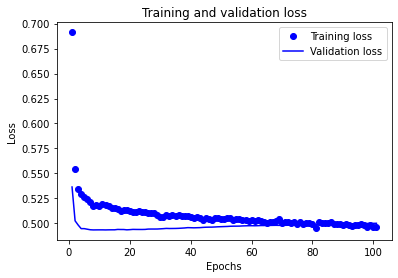

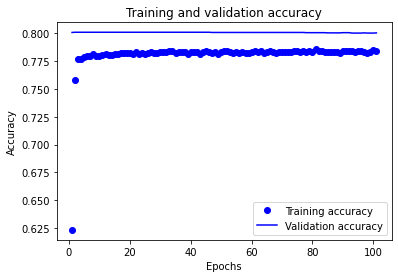

auc = 0.56840


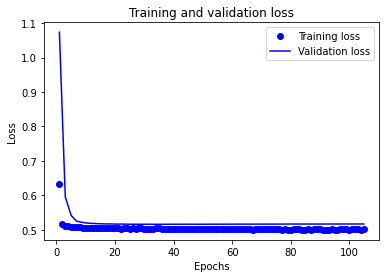

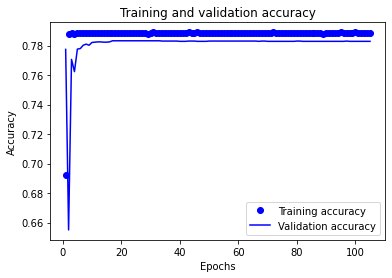

auc = 0.58268


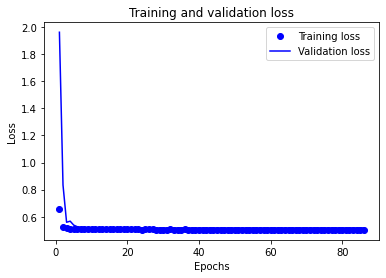

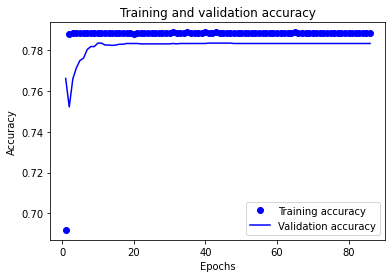

auc = 0.57438


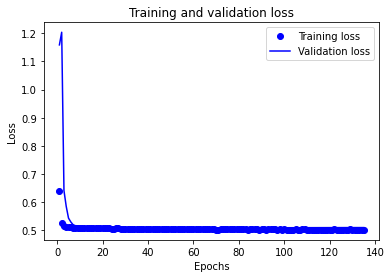

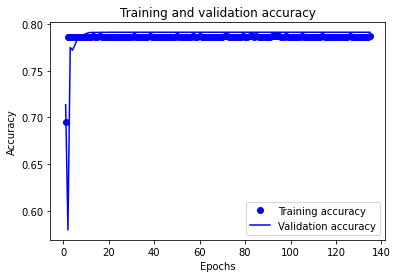

auc = 0.57322


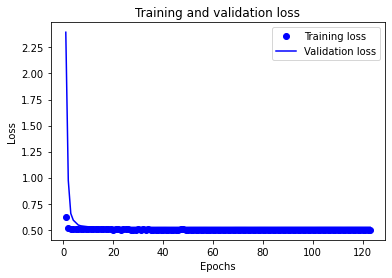

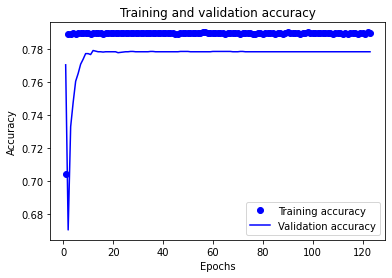

auc = 0.57538
0.5748125147237156 0.0046056355020093415
CPU times: user 1min 3s, sys: 5.58 s, total: 1min 9s
Wall time: 1min 8s


,id,pred_5
0,26570,0.220945
1,26571,0.170492
2,26572,0.179587
3,26573,0.207185
4,26574,0.352974
...,...,...
20770,47340,0.235027
20771,47341,0.181947
20772,47342,0.131183
20773,47343,0.236140


In [31]:
%%time
final_test_predictions = []
final_valid_predictions = {}
scores = []  # roc auc scores

for fold in range(5): #5
    x_train =  df_train_full[df_train_full.kfold != fold].reset_index(drop=True)
    x_val = df_train_full[df_train_full.kfold == fold].reset_index(drop=True)
    x_test = df_test.copy()
    
    valid_ids = x_val.id.values.tolist()
#     print(valid_ids)
    
    y_train = x_train.failure
    y_val = x_val.failure
    
    # to drop target colum
    x_train = x_train.drop(['id','failure'], axis=1)
    x_val = x_val.drop(['id','failure'], axis=1)
#     print(x_train.head())
    
    #preprocess
    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
        ])
    
    x_train = do_preprocess(x_train, preprocessor, train=True, missing_columns=True)
    x_val = do_preprocess(x_val, preprocessor, train=False, missing_columns=True)
    x_test = do_preprocess(x_test, preprocessor, train=False, missing_columns=True)
    
    # select model
    model = build_model()
    num_epochs = 200
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20)
    history = model.fit(x_train, y_train, 
                        validation_data=(x_val, y_val), 
                        epochs=num_epochs, 
                        batch_size=2048, 
                        verbose=0, 
                        callbacks=[lrate, early_stopping])

    plot_history(history)
    
    #Evaluating on Validation Set
    y_val_pred = model.predict(x_val).reshape(-1)
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict(x_test).reshape(-1)
        
    # save test and validation predictions on a list and a dict
    final_test_predictions.append(y_test_pred)
    final_valid_predictions.update(dict(zip(valid_ids, y_val_pred)))
    

print(np.mean(scores), np.std(scores))
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ["id", "pred_5"]
final_valid_predictions.to_csv("train_pred_5.csv", index=False)

submission = pd.DataFrame({'id': df_test.index, 'pred_5': y_test_pred})
submission['pred_5'] = np.mean(np.column_stack(final_test_predictions), axis=1)
submission.to_csv('test_pred_5.csv', index=False)
submission

<a id="17"></a> <br>
# Merge New Sets

In [32]:
df1 = pd.read_csv("train_pred_1.csv")
df2 = pd.read_csv("train_pred_2.csv")
df3 = pd.read_csv("train_pred_3.csv")
df4 = pd.read_csv("train_pred_4.csv")
df5 = pd.read_csv("train_pred_5.csv")

df_test1 = pd.read_csv("test_pred_1.csv")
df_test2 = pd.read_csv("test_pred_2.csv")
df_test3 = pd.read_csv("test_pred_3.csv")
df_test4 = pd.read_csv("test_pred_4.csv")
df_test5 = pd.read_csv("test_pred_5.csv")

df = df_train_full.copy()

df = df.merge(df1, on="id", how="left")
df = df.merge(df2, on="id", how="left")
df = df.merge(df3, on="id", how="left")
df = df.merge(df4, on="id", how="left")
df = df.merge(df5, on="id", how="left")

df_test = df_test.merge(df_test1, on="id", how="left")
df_test = df_test.merge(df_test2, on="id", how="left")
df_test = df_test.merge(df_test3, on="id", how="left")
df_test = df_test.merge(df_test4, on="id", how="left")
df_test = df_test.merge(df_test5, on="id", how="left")

print(df.columns)

df.head()

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'failure',
       'kfold', 'id', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'],
      dtype='object')


,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,...,measurement_16,measurement_17,failure,kfold,id,pred_1,pred_2,pred_3,pred_4,pred_5
0,A,80.10,material_7,material_8,9,5,7,8,4,18.040,...,14.684,764.100,0,1,0,0.203572,0.168595,0.199540,0.189811,0.132934
1,A,84.89,material_7,material_8,9,5,14,3,3,18.213,...,15.631,682.057,0,3,1,0.202581,0.142789,0.100677,0.096775,0.157917
2,A,82.43,material_7,material_8,9,5,12,1,5,18.057,...,17.946,663.376,0,3,2,0.204316,0.148549,0.144707,0.111586,0.160684
3,A,101.07,material_7,material_8,9,5,13,2,6,17.295,...,17.172,826.282,0,1,3,0.213422,0.201388,0.175702,0.178989,0.216600
4,A,188.06,material_7,material_8,9,5,9,2,8,19.346,...,16.412,579.885,0,2,4,0.233552,0.283609,0.242725,0.257352,0.312004


In [33]:
df_test.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,pred_1,pred_2,pred_3,pred_4,pred_5
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,13.659,16.825,13.742,17.710,634.612,0.214840,0.195868,0.258165,0.319162,0.220945
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,17.468,16.708,14.776,14.102,537.037,0.200431,0.182207,0.164945,0.188219,0.170492
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,13.363,15.737,17.065,16.021,658.995,0.206504,0.184548,0.163531,0.179230,0.179587
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,15.501,15.667,12.620,16.111,594.301,0.206974,0.182318,0.155549,0.146416,0.207185
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,16.070,16.183,13.324,17.150,801.044,0.248911,0.294681,0.283662,0.253436,0.352974


In [34]:
df.columns

Index(['product_code', 'loading', 'attribute_0', 'attribute_1', 'attribute_2',
       'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2',
       'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6',
       'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10',
       'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14',
       'measurement_15', 'measurement_16', 'measurement_17', 'failure',
       'kfold', 'id', 'pred_1', 'pred_2', 'pred_3', 'pred_4', 'pred_5'],
      dtype='object')

<a id="18"></a> <br>
# Blending Results

In [35]:
useful_features = ["pred_1", "pred_2", "pred_3", "pred_4", "pred_5"]

numerical_cols_2 = [c for c in df_train.columns if df_train[c].dtypes in ['int', 'float']]
print("Numerical Columns\n", numerical_cols)

categorical_cols = [c for c in df_train.columns if df_train[c].dtypes in ['object']]
print("\nCategorical Columns\n", categorical_cols)

Numerical Columns
 ['loading', 'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1', 'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5', 'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9', 'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13', 'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']

Categorical Columns
 ['product_code', 'attribute_0', 'attribute_1']


In [36]:
useful_features = ["pred_1", "pred_2", "pred_3", "pred_4", "pred_5"]
# df_test = df_test[useful_features]

# useful_features = np.concatenate((numerical_cols_2, categorical_cols, useful_features))

final_predictions = []
scores = []

for fold in range(5):
    x_train =  df[df.kfold != fold]
    x_val = df[df.kfold == fold]
    x_test = df_test.copy()

    y_train = x_train.failure
    y_val = x_val.failure

        
    x_train = x_train[useful_features]
    x_val = x_val[useful_features]
    x_test = x_test[useful_features]
    
    #preprocess
    preprocessor = StandardScaler()
    
    x_train = preprocessor.fit_transform(x_train)
    x_val = preprocessor.transform(x_val)
    x_test =  preprocessor.transform(x_test)
    
    # train model
#     model = LogisticRegression()
    model = LogisticRegression(max_iter=500, C=0.0001, penalty='l2', solver='newton-cg')
    model.fit(x_train, y_train)
    
    #Evaluating on Validation Set
    y_val_pred = model.predict_proba(x_val)[:,1]
    score = roc_auc_score(y_val, y_val_pred)
    print(f"auc = {score:.5f}")
    scores.append(score)
    
    # predict test set
    y_test_pred = model.predict_proba(x_test)[:,1]  
    
    preds_valid = model.predict(x_val)
    test_preds = model.predict(x_test)
    
    final_predictions.append(y_test_pred)
    

print(np.mean(scores), np.std(scores))

auc = 0.59457
auc = 0.58748
auc = 0.58904
auc = 0.57742
auc = 0.58229
0.5861605678839028 0.005866738729778888


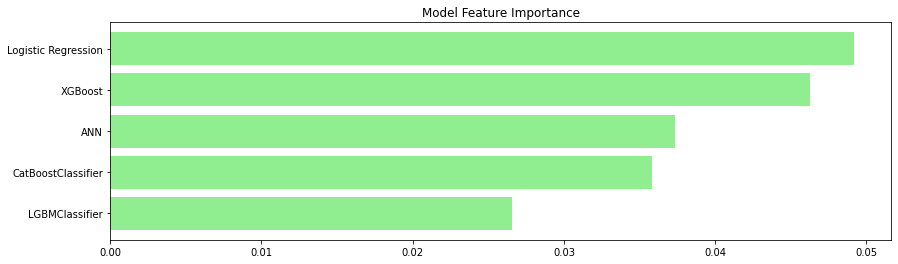

In [37]:
feature_importances = model.coef_.ravel()
model_names = ["Logistic Regression", "XGBoost", "CatBoostClassifier", "LGBMClassifier", 'ANN']
importance_df = plot_model_feature_importance(feature_importances, model_names, number_of_features=20)

<a id="30"></a> <br>
# Submission

In [38]:
sample_submission = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv')
sample_submission.head()

,id,failure
0,26570,0.0
1,26571,0.0
2,26572,0.0
3,26573,0.0
4,26574,0.0


In [39]:
sample_submission.failure = np.mean(np.column_stack(final_predictions), axis=1)
sample_submission.to_csv("submission.csv", index=False)
sample_submission

,id,failure
0,26570,0.220636
1,26571,0.191570
2,26572,0.194931
3,26573,0.194772
4,26574,0.267847
...,...,...
20770,47340,0.213050
20771,47341,0.182577
20772,47342,0.177435
20773,47343,0.210494
